# **Welcome!**
This is my take on the TPS-December using XGBoost. This was partially created with the findings of other users on the platform.

Contents:
1.  [Importing and reading data](#import)
2.  [Basic data prep work](#prep)
3.  [Data visualisation](#visual)
4.  [Time saving](#time)
5.  [Preparing data for model](#split)
6.  [Model evaluation](#eval)


### **Importing and reading data<a name = "import"></a>**

In order to get a good grasp of the data we are working with, let's display each csv that we were provided with. Using this, we can analyse which columns to remove, which column represents the target value as well as which columns require feature scaling.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder


train = pd.read_csv("/kaggle/input/tabular-playground-series-dec-2021/train.csv")
test = pd.read_csv("/kaggle/input/tabular-playground-series-dec-2021/test.csv")
submission = pd.read_csv("/kaggle/input/tabular-playground-series-dec-2021/sample_submission.csv")
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,0,3189,40,8,30,13,3270,206,234,193,...,0,0,0,0,0,0,0,0,0,1
1,1,3026,182,5,280,29,3270,233,240,106,...,0,0,0,0,0,0,0,0,0,2
2,2,3106,13,7,351,37,2914,208,234,137,...,0,0,0,0,0,0,0,0,0,1
3,3,3022,276,13,192,16,3034,207,238,156,...,0,0,0,0,0,0,0,0,0,2
4,4,2906,186,13,266,22,2916,231,231,154,...,0,0,0,0,0,0,0,0,0,2


In [2]:
test.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,4000000,2763,78,20,377,88,3104,218,213,195,...,0,0,0,0,0,0,0,0,0,0
1,4000001,2826,153,11,264,39,295,219,238,148,...,0,0,0,0,0,0,0,0,0,0
2,4000002,2948,57,19,56,44,852,202,217,163,...,0,0,1,0,0,0,0,0,0,0
3,4000003,2926,119,6,158,134,2136,234,240,142,...,0,0,0,0,0,0,0,0,0,0
4,4000004,2690,10,4,38,108,3589,213,221,229,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.describe()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
count,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,...,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06,4.000000e+06
mean,2.000000e+06,2.980192e+03,1.515857e+02,1.509754e+01,2.713154e+02,5.166262e+01,1.766642e+03,2.118375e+02,2.210614e+02,1.408109e+02,...,3.746200e-02,3.782075e-02,1.199500e-02,1.605350e-02,1.071275e-02,1.220750e-02,4.075150e-02,3.923925e-02,3.161850e-02,1.771335e+00
std,1.154701e+06,2.890482e+02,1.099611e+02,8.546731e+00,2.265497e+02,6.821597e+01,1.315610e+03,3.075996e+01,2.223134e+01,4.369864e+01,...,1.898910e-01,1.907625e-01,1.088629e-01,1.256813e-01,1.029465e-01,1.098111e-01,1.977140e-01,1.941637e-01,1.749822e-01,8.938060e-01
min,0.000000e+00,1.773000e+03,-3.300000e+01,-3.000000e+00,-9.200000e+01,-3.170000e+02,-2.870000e+02,-4.000000e+00,4.900000e+01,-5.300000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,9.999998e+05,2.760000e+03,6.000000e+01,9.000000e+00,1.100000e+02,4.000000e+00,8.220000e+02,1.980000e+02,2.100000e+02,1.150000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
50%,2.000000e+06,2.966000e+03,1.230000e+02,1.400000e+01,2.130000e+02,3.100000e+01,1.436000e+03,2.180000e+02,2.240000e+02,1.420000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
75%,2.999999e+06,3.217000e+03,2.470000e+02,2.000000e+01,3.610000e+02,7.800000e+01,2.365000e+03,2.330000e+02,2.370000e+02,1.690000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
max,3.999999e+06,4.383000e+03,4.070000e+02,6.400000e+01,1.602000e+03,6.470000e+02,7.666000e+03,3.010000e+02,2.790000e+02,2.720000e+02,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00


In [4]:
print(train["Cover_Type"].unique())

[1 2 3 6 7 4 5]


### **Basic data prep work<a name = "prep"></a>**



In [5]:
ds = pd.concat([train,test])
ds.drop(["Id"],axis=1,inplace = True)
ds.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,1.0
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,2.0
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,1.0
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,2.0
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,2.0


### **Data visualisation and fixing<a name = "visual"></a>**

<AxesSubplot:xlabel='Cover_Type', ylabel='count'>

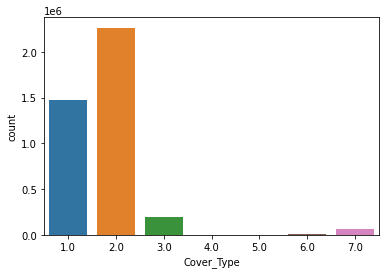

In [6]:
sns.countplot(data=ds,x="Cover_Type")

In [7]:
print(ds["Cover_Type"].value_counts())

2.0    2262087
1.0    1468136
3.0     195712
7.0      62261
6.0      11426
4.0        377
5.0          1
Name: Cover_Type, dtype: int64


<AxesSubplot:>

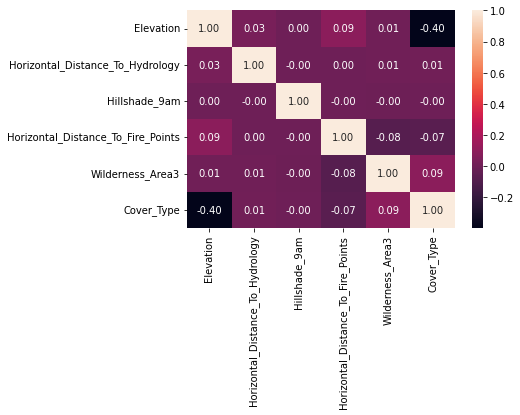

In [8]:
data_analysed = ds[["Elevation","Horizontal_Distance_To_Hydrology","Hillshade_9am","Horizontal_Distance_To_Fire_Points","Wilderness_Area3","Cover_Type"]]
sns.heatmap(data_analysed.corr(), annot=True, fmt='.2f')

In [9]:
cat_features = [col for col in ds.columns if ds[col].nunique() < 25]
print(cat_features)

['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']


In [10]:
for col in ds.columns:
    print(f"The total unique values in {col} are {len(ds[col].unique())}")

The total unique values in Elevation are 2548
The total unique values in Aspect are 440
The total unique values in Slope are 68
The total unique values in Horizontal_Distance_To_Hydrology are 1645
The total unique values in Vertical_Distance_To_Hydrology are 922
The total unique values in Horizontal_Distance_To_Roadways are 7786
The total unique values in Hillshade_9am are 302
The total unique values in Hillshade_Noon are 223
The total unique values in Hillshade_3pm are 326
The total unique values in Horizontal_Distance_To_Fire_Points are 8148
The total unique values in Wilderness_Area1 are 2
The total unique values in Wilderness_Area2 are 2
The total unique values in Wilderness_Area3 are 2
The total unique values in Wilderness_Area4 are 2
The total unique values in Soil_Type1 are 2
The total unique values in Soil_Type2 are 2
The total unique values in Soil_Type3 are 2
The total unique values in Soil_Type4 are 2
The total unique values in Soil_Type5 are 2
The total unique values in Soi

What we learned from data representation:

- There isn't an equal distribution for cover types.
- Most variables do not have any important correlation with each other, excluding cover type.
- The other data values are all continuous, and thus there is no need for one hot encoding for categorical values as the categorical values are already dealt with properly.
- There is only 1 value with cover_type 5 out of millions of data values. Thus to avoid confusing the model, we remove this cover_type entirely.
- Soil_Type7 and Soil_Type15 are all 0, so they are completely useless.

In [11]:
ds = ds[ds["Cover_Type"] != 5]
print(ds["Cover_Type"].value_counts())

2.0    2262087
1.0    1468136
3.0     195712
7.0      62261
6.0      11426
4.0        377
Name: Cover_Type, dtype: int64


In [12]:
ds.drop([ 'Soil_Type7', 'Soil_Type15'], axis=1,inplace = True)

## **Time saving<a name="time">**
    
Up to this point, I realised that this notebook were taking way too long with the gargantuan size of the data and thus looked to other notebooks for solutions to this issue.I found this solution from an amazing notebook and used it in my own.
    
<a href= "https://www.kaggle.com/code/leeyj0511/tps-dec-end-to-end-ml-project-for-beginner#3.-Explore-the-Data" >Original creator's notebook</a>
    
Note: The code from the notebook also seems to be copied from another user, so credit should also be given to that user :)

In [13]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

start = time.time()

ds=reduce_mem_usage(ds)

stop = time.time()
print(f"Time: {round((stop - start), 3)} seconds")

Mem. usage decreased to 348.09 Mb (83.1% reduction)
Time: 20.36 seconds


## **Splitting data into relevant values.<a name="split">**


In [14]:
x_test = ds[ds["Cover_Type"].isnull()].drop(["Cover_Type"],axis=1)
ds = ds.dropna()

y_train = ds["Cover_Type"]
le = LabelEncoder()
y_train = pd.DataFrame(le.fit_transform(y_train))
x_train = ds.drop(["Cover_Type"],axis=1)

x_train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,3189,40,8,30,13,3270,206,234,193,4873,...,0,0,0,0,0,0,0,0,0,0
1,3026,182,5,280,29,3270,233,240,106,5423,...,0,0,0,0,0,0,0,0,0,0
2,3106,13,7,351,37,2914,208,234,137,5269,...,0,0,0,0,0,0,0,0,0,0
3,3022,276,13,192,16,3034,207,238,156,2866,...,0,0,0,0,0,0,0,0,0,0
4,2906,186,13,266,22,2916,231,231,154,2642,...,0,0,0,0,0,0,0,0,0,0


## **Model Evaluation<a name = "eval">**
    
We will be using extreme gradient boosting for this example.
Note that the best parameters were taken from a discussion that was linked previously, as it would be difficult to derive the best parameters without using randomizedsearchcv.

In [15]:
best_params = {
    "n_estimators": 1700,
    "max_depth": 12,
    "learning_rate": 0.01146513635635539,
    "gamma": 0.2594531967123816,
    "min_child_weight": 3.4942992853505186,
    "subsample": 0.6257232748066737,
    "colsample_bytree": 0.626827539397344,
    "reg_alpha": 6,
    "reg_lambda": 87
}

feat_imp = pd.Series(0, index=x_test.columns)
test_preds = np.zeros((1, 1))
scores = []

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

for fold, (train_idx, val_idx) in enumerate(cv.split(x_train, y_train)):
    X_train, X_val = x_train.iloc[train_idx, :], x_train.iloc[val_idx, :]
    Y_train, Y_val = y_train.iloc[train_idx, :], y_train.iloc[val_idx, :]

    clf = XGBClassifier(**best_params, tree_method="gpu_hist", use_label_encoder=False)
    clf.fit(
        X_train,
        Y_train,
        eval_set=[(X_val, Y_val)],
        verbose=False,
        eval_metric="mlogloss"
    )

    y_pred = clf.predict(X_val)
    score = accuracy_score(Y_val, y_pred)
    scores.append(score)

    feat_imp = feat_imp + pd.Series(clf.get_booster().get_score(importance_type="gain"))
    test_preds = test_preds + clf.predict_proba(x_test)

    print(f"Fold {fold} Accuracy: {score}")

print()
print(f"Mean Accuracy: {np.mean(scores)}")

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 0 Accuracy: 0.96078


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 1 Accuracy: 0.9601775


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 2 Accuracy: 0.9607575


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 3 Accuracy: 0.9601725


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 4 Accuracy: 0.9602625


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 5 Accuracy: 0.9602975


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 6 Accuracy: 0.9603025


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 7 Accuracy: 0.960725


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 8 Accuracy: 0.9606925


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


Fold 9 Accuracy: 0.960479901199753

Mean Accuracy: 0.9604647401199753


In [16]:
submission["Cover_Type"] = test_preds
submission.to_csv("submission.csv", index=False)